In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,test_obs
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


In [2]:

df_dow = YahooDownloader(start_date = DATA_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
# df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = NAS_100_TICKER).fetch_data()
# df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = HSI_50_TICKER).fetch_data()
# df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = DAX_30_TICKER).fetch_data()

# df_sp500 = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (185454, 8)


In [7]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')
df_sp500.to_csv('./data/sp500.csv')

In [ ]:
# df_dow =read_csv('./data/dow.csv')
# df_nasdaq =read_csv('./data/nasdaq.csv')
# df_hsi = read_csv('./data/hsi.csv')
# df_dax = read_csv('./data/dax.csv')
# df_sp500 = read_csv('./data/sp500.csv')

In [3]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)


Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [24]:
def train(train_data,test_data,INDICATORS,model_name,model_parameters,iterations,save = True,load_model = False):
    stock_dimension = len(train_data.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    buy_cost_list = sell_cost_list = [0.001] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold" : 70
    }


    train_environment = StockTradingEnv(df = train_data, **env_kwargs)
    test_environment = StockTradingEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name
                                    ,model_kwargs = model_parameters)
    if not load_model:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations)
    else:
      print('loading model')
      model = model_agent.load('./data/'+str(model_name)+str(iterations),env =train_environment)
    if save and not load_model:
        model.save('./data/'+str(model_name)+str(iterations))
    predictions = DRLAgent.DRL_prediction(model, test_environment)
    predictions[0].date = pd.to_datetime(predictions[0].date )
    return predictions,test_environment.state_memory


In [26]:
td3_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_000,load_model=True)


Stock Dimension: 26, State Space: 79
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!


state shape is account value + prices + current holding of stocks +   + indocators values for each stock

# Todo : change reward function

In [27]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}

ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,100_000,False,load_model=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,100_000,False,load_model=True)
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,100_000,False,load_model=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,100_000,False,load_model=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_000,False,load_model=True)



Stock Dimension: 26, State Space: 79
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!
Stock Dimension: 26, State Space: 79
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!
Stock Dimension: 26, State Space: 79
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
hit end!
Stock Dimension: 26, State Space: 79
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.

In [28]:
td3_predictions[0][1]

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,HD,HON,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-04,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-05,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-06,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-09,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-09-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-09-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
td3_predictions[0][1:len(train_data.tic.unique())+1]

(            AAPL  AMGN  AXP  BA  CAT  CSCO  CVX  DIS   HD  HON  ...  MMM  MRK  \
 date                                                            ...             
 2023-01-03     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-04     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-05     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-06     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-09     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 ...          ...   ...  ...  ..  ...   ...  ...  ...  ...  ...  ...  ...  ...   
 2024-09-23     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-24     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-25     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-26     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-27     

In [30]:
td3_predictions[0][1:len(train_data.tic.unique())+1]

(            AAPL  AMGN  AXP  BA  CAT  CSCO  CVX  DIS   HD  HON  ...  MMM  MRK  \
 date                                                            ...             
 2023-01-03     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-04     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-05     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-06     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 2023-01-09     0   100    0   0  100     0  100    0  100    0  ...    0  100   
 ...          ...   ...  ...  ..  ...   ...  ...  ...  ...  ...  ...  ...  ...   
 2024-09-23     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-24     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-25     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-26     0     0    0   0    0     0    0    0    0    0  ...    0    0   
 2024-09-27     

In [31]:
states = np.array(td3_predictions[1])
len(states[0])

79

In [32]:
states = states[:,1:len(train_data.tic.unique())+1]
len(states[0])

26

In [33]:
prices = pd.DataFrame(states,columns= train_data.tic.unique())
prices

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,HD,HON,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
0,125.045044,248.038605,146.590714,203.639999,232.784485,45.038406,158.791260,91.260178,305.235565,201.205719,...,95.369331,106.981995,225.400925,118.245636,144.854874,180.515320,491.232483,35.922073,32.329597,46.744358
1,123.718979,250.355820,143.082779,204.990005,231.742859,44.403801,161.650879,91.200638,301.168701,195.870010,...,93.700478,108.471039,218.720535,117.670090,143.056442,180.823853,477.074829,36.419895,30.346184,46.585030
2,128.271088,258.180054,146.737305,213.000000,240.018005,45.767738,162.868484,93.184990,303.135315,201.426025,...,96.565735,109.616455,221.298248,121.484451,146.463013,186.917191,477.113770,36.847855,31.570728,47.726330
3,128.795578,253.414185,146.962021,208.570007,237.857559,46.014008,161.595520,94.028336,303.402618,201.809219,...,96.619080,105.359322,223.452881,121.796623,144.674072,182.337524,477.172241,36.699699,31.346510,47.131290
4,129.369553,256.941650,148.525452,206.690002,241.609375,46.231857,162.388809,94.812157,306.094788,202.451050,...,97.640205,105.769760,225.154953,122.762413,144.531372,184.362244,473.218994,37.214222,31.648340,47.102036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,227.120117,328.294678,265.516205,155.809998,384.548370,52.121670,145.961075,93.690002,400.660004,204.264435,...,136.494080,114.959999,428.312683,87.459999,172.227402,237.979996,575.190002,43.973545,8.278526,80.669998
433,226.121216,310.377930,265.476318,152.220001,376.895874,52.250683,142.516205,93.919998,396.929993,205.767029,...,135.877365,114.730003,431.246796,88.000000,171.253113,236.320007,576.309998,43.865234,8.006781,81.400002
434,227.269958,316.568451,267.451141,154.580002,389.560364,52.449162,140.556213,95.199997,396.700012,206.015808,...,138.702332,113.089996,430.448395,89.389999,172.197571,236.050003,574.809998,43.934158,8.268822,79.919998
435,227.539658,320.110138,270.353546,156.320007,389.679932,52.617874,144.020874,96.010002,399.529999,206.612869,...,136.573654,113.690002,427.164948,89.440002,172.535583,236.110001,581.849976,44.200008,8.792902,79.779999


In [34]:
actions = td3_predictions[0][1]
actions

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,HD,HON,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-04,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-05,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-06,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
2023-01-09,0,100,0,0,100,0,100,0,100,0,...,0,100,0,100,0,0,0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-09-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-09-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
weights =pd.DataFrame((prices.values*actions.values), columns=actions.columns, index=actions.index) 

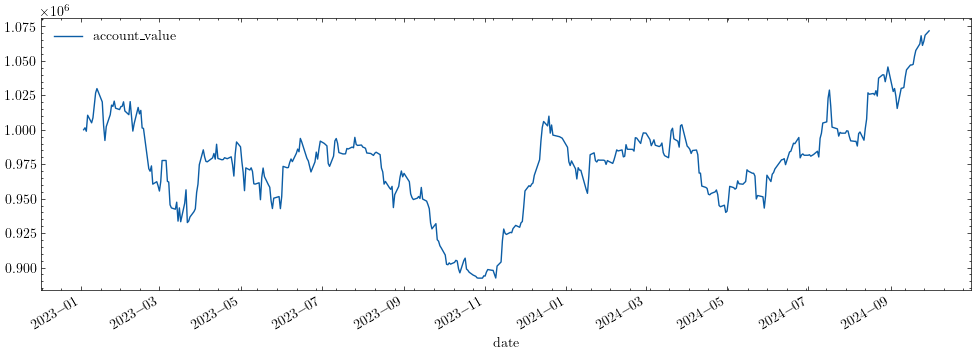

In [77]:
%matplotlib inline
with plt.style.context('science','ieee'):

    td3_predictions[0][0].plot(x='date',y='account_value',figsize=(12,4))


In [39]:
from pypfopt import expected_returns

df = processed_dax.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]
cov_list = []
mu= []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    mu.append(expected_returns.mean_historical_return(price_lookback))
    cov_list.append(covs)
df_cov = pd.DataFrame(
{'time': df.date.unique()[lookback:], 'cov_list': cov_list,'returns':mu})
df = df.merge(df_cov, left_on='date',right_on='time')

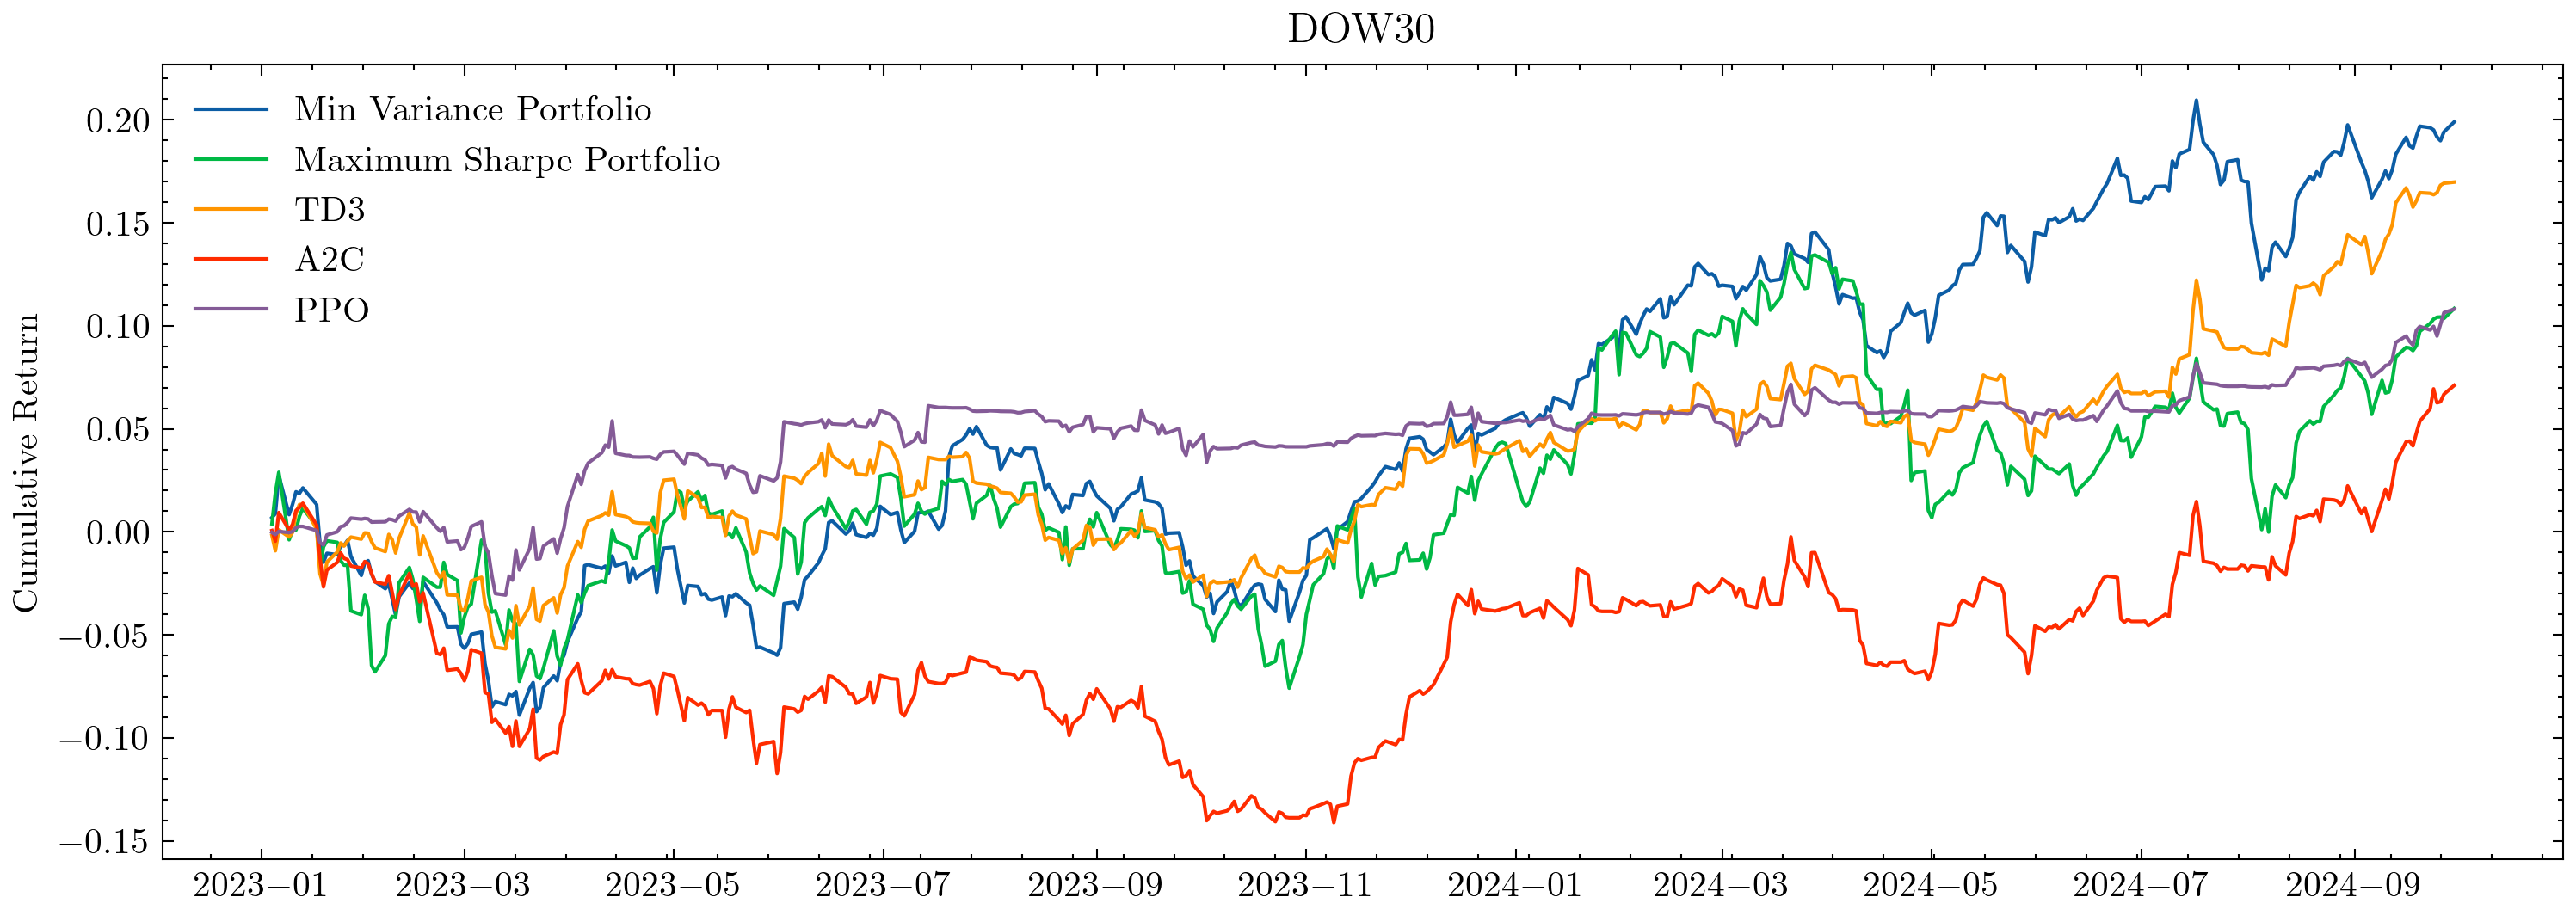

In [96]:



with plt.style.context('science','ieee'):
    
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(markowitz_history_df.date,(markowitz_history_df.total_assets.pct_change() +1).cumprod() -1,label='Min Variance Portfolio') 
    plt.plot(performance_sharpe.date,(performance_sharpe.total_assets.pct_change() +1).cumprod()-1,label='Maximum Sharpe Portfolio') 
    plt.plot(td3_predictions[0].date,(td3_predictions[0].account_value.pct_change() +1).cumprod()-1,label='TD3') 
    plt.plot(a2c_predictions[0].date,(a2c_predictions[0].account_value.pct_change() +1).cumprod()-1,label='A2C') 
    plt.plot(ppo_predictions[0].date,(ppo_predictions[0].account_value.pct_change() +1).cumprod()-1,label='PPO') 
    plt.legend()
    
    plt.ylabel('Cumulative Return')
    plt.title('DOW30')
    plt.show()

In [ ]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features
Stock Dimension: 25, State Space: 76


In [70]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "turbulence_threshold" : 70
}


train_environment = StockTradingEnv(df = train_data, **env_kwargs)
test_environment = StockTradingEnv(df = test_data, **env_kwargs)


In [72]:
agent = DRLAgent(env = train_environment)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo"
                            ,model_kwargs = PPO_PARAMS)

ppo_model = agent.train_model(model=model_ppo, 
                            tb_log_name='ppo',
                            total_timesteps=50_000)
ppo_model.save('./data/ppo_dow30_2000_2020_50000')
ppo_predictions = DRLAgent.DRL_prediction(ppo_model, test_environment)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/              |             |
|    fps             | 48          |
|    iterations      | 1           |
|    time_elapsed    | 42          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.02734061 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2           |
|    time_elapsed         | 85          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012285264 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.5       |
|    explained_variance   | 0 